# Biases of TOA radiative fluxes btw CNRM-CM6-1 PPE and CERES dataset 
Here we want to estimate the biases in TOA radiative fluxes (SW, LW and Net) between the members of CNRM-CM6-1 PPE and the CERES observation dataset. The idea is to get metrics assessing the skill of the models, especially in regard of the feedbacks in these models.

# Importe modules

In [14]:
# Computational modules 
%matplotlib inline
import xarray as xr
import glob
import os
import numpy as np
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import re
from array import array
from pylab import *
#import geopandas

# Plotting modules 
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
import pandas.plotting
import matplotlib.ticker as ticker
import seaborn as sns

# Functions definition

In [15]:
import sys
sys.path.append('/data/home/globc/peatier/CNRMppe')
import Fonctions
from Fonctions import get_wavg_budget_df
from Fonctions import wavg 
from Fonctions import plotlines_Xdf
from Fonctions import plotlines_1df
from Fonctions import Deltas_Lambda

# Read files : radiative budget, tas

## Observations CERES

In [16]:
def load_monthly_clim(path, filename, variables) :
    
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    df=file[variables].to_dataframe()
    
    # Compute Climatological Annual Cycle :
    df1=df.reset_index(level=['time', 'lat', 'lon'])
    df1['month']=pd.DatetimeIndex(df1['time']).month # time in years
    df_mean=df1.groupby(['month', 'lat', 'lon']).mean()
    
    return df_mean

In [17]:
#...................................................................
# GLOBAL MEAN WEIGHTED WITH COS(LAT)

import xarray as xr
import numpy as np
import pandas as pd


def wavg(df, start_yr, variables):
    # First, we need to convert latitude to radians and the time into year
    df1=df.reset_index(level=['month', 'lat'])
    df1['latr'] = np.deg2rad(df1['lat']) # lat in radians 


    # Then, we find the zonal mean by averaging along the latitude circles
    df2=df1.groupby(['month', 'lat']).mean()

    # Finally, we use the cosine of the converted latitudes as weights for the average
    df2['weights'] = np.cos(df2['latr'])
    result=pd.DataFrame()
    df2_tmp=df2.groupby(['month']).mean()
    result[variables]=df2_tmp[variables]
    N=len(result)
    YR=start_yr
    i=0
    while i < N:
        yr=YR+i
        tmp=df2.loc[yr]
        n=len(variables)
        j=0
        while j < n:
            t = (tmp[variables[j]]*tmp['weights']).sum()/tmp['weights'].sum()
            result[variables[j]].iloc[i]=t
            j = j + 1
        i = i + 1

    #r = result.mean()
    return result

In [18]:
path_observation = '/data/home/globc/peatier/obs_data/'
filename = 'CERES_EBAF-TOA_Ed4.1_Subset_200003-201910_regrid.nc'
    
# Load data and compute Annual Cycle :
file = xr.open_mfdataset(path_observation+filename,combine='by_coords')
#file
variables = ['toa_sw_all_mon','toa_lw_all_mon', 'toa_net_all_mon']
df_obs = load_monthly_clim(path_observation, filename, variables)#.to_xarray()
#df_global = wavg(df, 1, variables).to_xarray()
df_obs

toa_sw_all_mon  toa_lw_all_mon  toa_net_all_mon
month lat        lon                                                       
1     -88.927735 0.00000        344.953522      189.246185       -38.599289
                 1.40625        344.953522      189.246185       -38.599289
                 2.81250        344.953522      189.246185       -38.599289
                 4.21875        344.992493      189.144440       -38.531315
                 5.62500        345.007721      189.104630       -38.504715
...                                    ...             ...              ...
12     88.927735 352.96875        0.000000      171.476639      -171.476639
                 354.37500        0.000000      171.476639      -171.476639
                 355.78125        0.000000      171.500351      -171.500351
                 357.18750        0.000000      171.560974      -171.560974
                 358.59375        0.000000      171.560974      -171.560974

[393216 rows x 3 columns]

## Second PPE : amip and amip-future4K

In [19]:
path_official='/data/scratch/globc/peatier/CMIP6/CNRM-CM6-1/CFMIP/amip/'
path_PPE='/data/scratch/globc/peatier/CNRM-CM6-1_PPE/'
variables = ['rlut', 'rsut','rsdt','tas']

# The amip experiments, new ensemble LHS500 : 

start_yr=1979
drop=False
year_list=None
nb_p_list_LHS500 =['p311', 'p312', 'p314', 'p316',
                    'p317', 'p319', 'p320', 'p321', 'p322', 'p324', 'p325', 'p326', 
                    'p329', 'p330', 'p331', 'p332', 'p335', 'p336', 'p337' ,'p338', 
                    'p340', 'p341', 'p343', 'p344', 'p346', 'p347', 'p348', 'p349', 
                    'p350', 'p353', 'p355', 'p357', 'p359', 'p360', 
                    'p361', 'p363', 'p365', 'p367', 'p368', 'p369', 
                    'p372', 'p373', 'p374', 'p375', 'p376', 'p378', 'p381', 'p382', 
                    'p384', 'p386', 'p388', 'p389', 'p391', 'p392', 'p393', 
                    'p394', 'p395', 'p396', 'p398', 'p399', 'p400', 'p404', 
                    'p406', 'p407', 'p409', 'p410', 'p411', 'p412']
N=len(nb_p_list_LHS500)
amip_LHS500={}
i = 0
while i<N:
    nb_p_LHS500 = nb_p_list_LHS500[i]
    print(nb_p_LHS500)
    path=path_PPE+'CNRM-CM6-1_amip_LHS500_PPE/CNRM-CM6-1_amip_r1i1'+nb_p_LHS500+'f2/'
    filename = '*_CNRM-CM6-1_amip_r1i1'+nb_p_LHS500+'f2*.nc'
    amip_LHS500[str(nb_p_LHS500) + "_amip"] = load_monthly_clim(path, filename, variables)
    #amip_LHS500[str(nb_p_LHS500) + "_amip"] = wavg(tmp, 1, variables)
    i=i+1
    

p311
p312
p314
p316
p317
p319
p320
p321
p322
p324
p325
p326
p329
p330
p331
p332
p335
p336
p337
p338
p340
p341
p343
p344
p346
p347
p348
p349
p350
p353
p355
p357
p359
p360
p361
p363
p365
p367
p368
p369
p372
p373
p374
p375
p376
p378
p381
p382
p384
p386
p388
p389
p391
p392
p393
p394
p395
p396
p398
p399
p400
p404
p406
p407
p409
p410
p411
p412


In [20]:
PPE = {}
for i in nb_p_list_LHS500 :
    df = amip_LHS500[str(i) + "_amip"]
    df['SW'] = df['rsdt'] - df['rsut']
    df['N'] = df['SW'] - df['rlut']
    PPE[str(i)] = df#.to_xarray() 
    

In [21]:
PPE[str(i)]

rlut        rsut        rsdt         tas  \
month lat        lon                                                         
1     -88.927735 0.00000    189.339066  362.730652  497.452148  248.492737   
                 1.40625    189.339066  362.730652  497.452148  248.492737   
                 2.81250    189.339066  362.730652  497.452148  248.492737   
                 4.21875    189.339066  362.730652  497.452148  248.492737   
                 5.62500    189.339066  362.730652  497.452148  248.492737   
...                                ...         ...         ...         ...   
12     88.927735 352.96875  169.941864    0.000000    0.000000  246.629990   
                 354.37500  169.941864    0.000000    0.000000  246.629990   
                 355.78125  169.941864    0.000000    0.000000  246.629990   
                 357.18750  169.941864    0.000000    0.000000  246.629990   
                 358.59375  169.941864    0.000000    0.000000  246.629990   

                            height          SW           N  
month lat        lon                                        
1     -88.927735 0.00000       2.0  134.721497  -54.617569  
                 1.40625       2.0  134.721497  -54.617569  
                 2.81250       2.0  134.721497  -54.617569  
                 4.21875       2.0  134.721497  -54.617569  
                 5.62500       2.0  134.721497  -54.617569  
...                            ...         ...         ...  
12     88.927735 352.96875     2.0    0.000000 -169.941864  
                 354.37500     2.0    0.000000 -169.941864  
                 355.78125     2.0    0.000000 -169.941864  
                 357.18750     2.0    0.000000 -169.941864  
                 358.59375     2.0    0.000000 -169.941864  

[393216 rows x 7 columns]

## Compute biases

In [22]:
for i in nb_p_list_LHS500 :
    print(i)
    amip_LHS500[str(i) + "_amip"]['bias_SW'] = amip_LHS500[str(i) + "_amip"]['rsut'] - df_obs['toa_sw_all_mon']
    amip_LHS500[str(i) + "_amip"]['bias_LW'] = amip_LHS500[str(i) + "_amip"]['rlut'] - df_obs['toa_lw_all_mon']
    amip_LHS500[str(i) + "_amip"]['bias_N'] = amip_LHS500[str(i) + "_amip"]['N'] - df_obs['toa_net_all_mon']

p311
p312
p314
p316
p317
p319
p320
p321
p322
p324
p325
p326
p329
p330
p331
p332
p335
p336
p337
p338
p340
p341
p343
p344
p346
p347
p348
p349
p350
p353
p355
p357
p359
p360
p361
p363
p365
p367
p368
p369
p372
p373
p374
p375
p376
p378
p381
p382
p384
p386
p388
p389
p391
p392
p393
p394
p395
p396
p398
p399
p400
p404
p406
p407
p409
p410
p411
p412


In [23]:
variables = ['bias_SW','bias_LW','bias_N']
Biases_globalAVG = {}
for i in nb_p_list_LHS500 :
    print(i)
    df = amip_LHS500[str(i) + "_amip"].abs()
    Biases_globalAVG[str(i)] = wavg(df,1,variables)

p311
p312
p314
p316
p317
p319
p320
p321
p322
p324
p325
p326
p329
p330
p331
p332
p335
p336
p337
p338
p340
p341
p343
p344
p346
p347
p348
p349
p350
p353
p355
p357
p359
p360
p361
p363
p365
p367
p368
p369
p372
p373
p374
p375
p376
p378
p381
p382
p384
p386
p388
p389
p391
p392
p393
p394
p395
p396
p398
p399
p400
p404
p406
p407
p409
p410
p411
p412


## Create plot

In [24]:
def plotlines_Xdf(df, y, title, colors, linewidth, xlabel, xmin, xmax, ymin, ymax):
    ax_model=plt.gca()
    N=len(df)
    i=0
    while i < N:
        df[i].plot(y=y,kind='line',title=title,legend=False, color=colors[i],linewidth=linewidth[i],ax=ax_model)
        i = (i+1)

    plt.xlabel(xlabel)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    #ax_model.legend(legend, loc='center left', bbox_to_anchor=(1, 0.5))

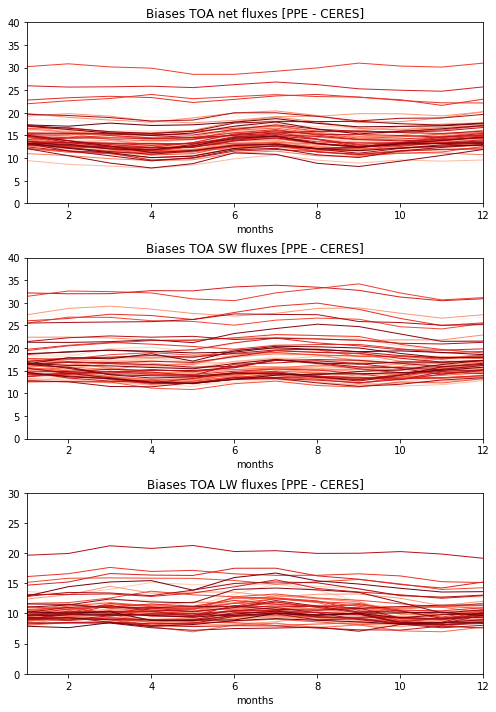

In [14]:
n = len(nb_p_list_LHS500)
df = [None]*n
df[:] = [Biases_globalAVG[str(i)]for i in nb_p_list_LHS500]

# Plot of lines from different dataframes
plt.subplots(figsize=(7,10)) 

plt.subplot(311)
title = 'Biases TOA net fluxes [PPE - CERES]'
y = 'bias_N'
ymin = 0.0
ymax = 40.0
cmap2 = plt.get_cmap('Reds')
colors = [cmap2(i) for i in np.linspace(0, 1, len(nb_p_list_LHS500))]
linewidth = [1.0]*n
xmin = 1.0
xmax = 12.0
xlabel='months'
plotlines_Xdf(df, y, title, colors, linewidth, xlabel, xmin, xmax, ymin, ymax)

plt.subplot(312)
title = 'Biases TOA SW fluxes [PPE - CERES]'
y = 'bias_SW'
ymin = 0.0
ymax = 40.0
cmap2 = plt.get_cmap('Reds')
colors = [cmap2(i) for i in np.linspace(0, 1, len(nb_p_list_LHS500))]
linewidth = [1.0]*n
xmin = 1.0
xmax = 12.0
xlabel='months'
plotlines_Xdf(df, y, title, colors, linewidth, xlabel, xmin, xmax, ymin, ymax)

plt.subplot(313)
title = 'Biases TOA LW fluxes [PPE - CERES]'
y = 'bias_LW'
ymin = 0.0
ymax = 30.0
cmap2 = plt.get_cmap('Reds')
colors = [cmap2(i) for i in np.linspace(0, 1, len(nb_p_list_LHS500))]
linewidth = [1.0]*n
xmin = 1.0
xmax = 12.0
xlabel='months'
plotlines_Xdf(df, y, title, colors, linewidth, xlabel, xmin, xmax, ymin, ymax)

#Ajustement des subplots
plt.tight_layout()
plt.subplots_adjust(hspace = 0.30)

plt.show()

In [27]:
# Plot error VS Feedbacks
Feedbacks = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/files/npy/Net_feedbacks.npy")

In [28]:
n = len(nb_p_list_LHS500)
PPE_BiasN = [1]*(n)
PPE_BiasSW = [1]*(n)
PPE_BiasLW = [1]*(n)
j=0
for i in nb_p_list_LHS500 :
    df = Biases_globalAVG[str(i)]
    PPE_BiasN[j] = df['bias_N'].mean()
    PPE_BiasSW[j] = df['bias_SW'].mean()
    PPE_BiasLW[j] = df['bias_LW'].mean()
    j+=1

PPE_Bias_df = pd.DataFrame(PPE_BiasN, columns=['bias_N'])
PPE_Bias_df['bias_N'] = PPE_Bias_df['bias_N']
PPE_Bias_df['bias_SW'] = PPE_BiasSW
PPE_Bias_df['bias_SW'] = PPE_Bias_df['bias_SW']
PPE_Bias_df['bias_LW'] = PPE_BiasLW
PPE_Bias_df['bias_LW'] = PPE_Bias_df['bias_LW']
PPE_Bias_df['N'] = Feedbacks
PPE_Bias_df

,bias_N,bias_SW,bias_LW,N
0,22.680768,27.247898,10.496304,-0.789073
1,15.279618,15.596387,10.165805,-1.666454
2,18.777535,14.220888,11.602198,-1.214114
3,16.074992,16.675899,11.300294,-1.292415
4,18.009851,18.631144,9.273055,-0.756525
...,...,...,...,...
63,13.045434,15.041107,9.222363,-1.321747
64,16.325236,16.529284,9.780520,-1.604550
65,13.121681,18.559264,14.682673,-1.118935
66,11.967703,13.946729,8.390613,-1.279246


In [29]:
bias_N = PPE_Bias_df['bias_N'] 

# Save the numpy array in a file   
np.save('/data/home/globc/peatier/CNRMppe/PPE/files/npy/PPE2_bias_N.npy', bias_N)

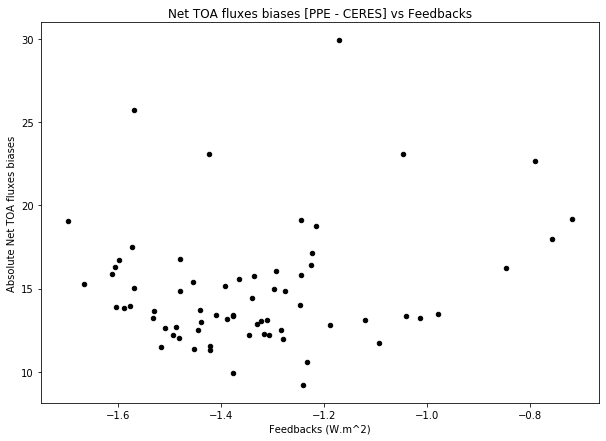

In [17]:
ax = plt.gca()
title = 'Net TOA fluxes biases [PPE - CERES] vs Feedbacks'
PPE_Bias_df.plot(kind='scatter', x='N', y='bias_N', color='black', figsize=(10, 7), 
                     style='.', ax = ax)
#plt.plot(X_test, y_pred, color='blue', linewidth=1.0)

plt.xlabel('Feedbacks (W.m^2)')
plt.ylabel('Absolute Net TOA fluxes biases')
plt.title(title)
plt.show()

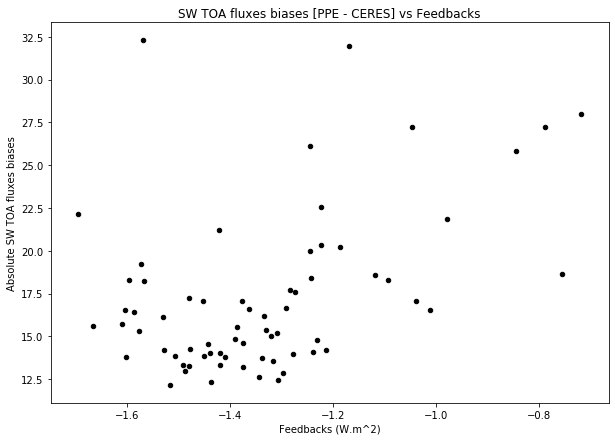

In [18]:
ax = plt.gca()
title = 'SW TOA fluxes biases [PPE - CERES] vs Feedbacks'
PPE_Bias_df.plot(kind='scatter', x='N', y='bias_SW', color='black', figsize=(10, 7), 
                     style='.', ax = ax)
#plt.plot(X_test, y_pred, color='blue', linewidth=1.0)

plt.xlabel('Feedbacks (W.m^2)')
plt.ylabel('Absolute SW TOA fluxes biases')
plt.title(title)
plt.show()

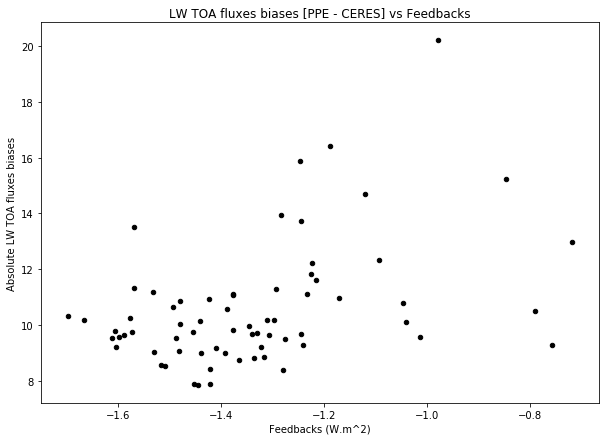

In [19]:
ax = plt.gca()
title = 'LW TOA fluxes biases [PPE - CERES] vs Feedbacks'
PPE_Bias_df.plot(kind='scatter', x='N', y='bias_LW', color='black', figsize=(10, 7), 
                     style='.', ax = ax)
#plt.plot(X_test, y_pred, color='blue', linewidth=1.0)

plt.xlabel('Feedbacks (W.m^2)')
plt.ylabel('Absolute LW TOA fluxes biases')
plt.title(title)
plt.show()